# Import Libraries

In [ ]:
pip install nilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 78.2 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2


In [ ]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
#!pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif
#import gif_your_nifti.core as gif2nif

# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#/content/drive/MyDrive/BRATS

Mounted at /content/drive


In [ ]:
# DEFINE seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include

In [ ]:
SEGMENT_CLASSES.values()

dict_values(['NOT tumor', 'NECROTIC/CORE', 'EDEMA', 'ENHANCING'])

In [ ]:
import nibabel as nib
TRAIN_DATASET_PATH = '/content/drive/MyDrive/BRATS/ASNR-MICCAI-BraTS2023-PED-Challenge-TrainingData/'
#/Users/trl102/Downloads/ASNR-MICCAI-BraTS2023-PED-Challenge-TrainingData/BraTS-PED-00002-000
# Load the NIfTI file
#nifti_image = nib.load('path/to/nifti/file.nii.gz')
nifti_image=nib.load(TRAIN_DATASET_PATH + 'BraTS-PED-00002-000/BraTS-PED-00002-000-t1c.nii.gz')


# Get the header information
header = nifti_image.header

# Print some information from the header
print('Image dimensions:', header.get_data_shape())
print('Voxel size (mm):', header.get_zooms())
print('Data type:', header.get_data_dtype())


Image dimensions: (240, 240, 155)
Voxel size (mm): (1.0, 1.0, 1.0)
Data type: float32


80


Text(0.5, 1.0, 'Mask')

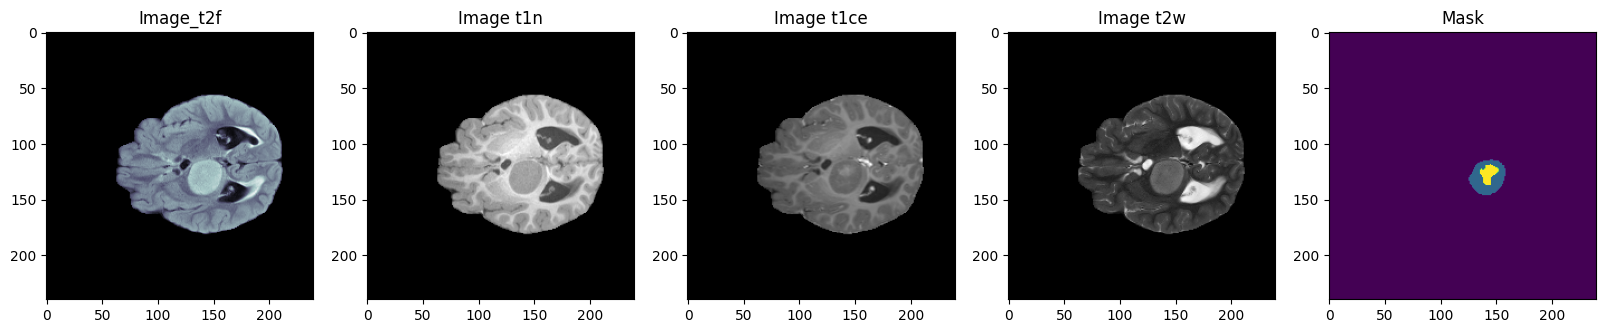

In [ ]:
TRAIN_DATASET_PATH = '/content/drive/MyDrive/BRATS/ASNR-MICCAI-BraTS2023-PED-Challenge-TrainingData/'
VALIDATION_DATASET_PATH = '/content/drive/MyDrive/BRATS/ASNR-MICCAI-BraTS2023-PED-Challenge-ValidationData/'
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS-PED-00002-000/BraTS-PED-00002-000-t2f.nii.gz').get_fdata()
test_image_t1n=nib.load(TRAIN_DATASET_PATH + 'BraTS-PED-00002-000/BraTS-PED-00002-000-t1n.nii.gz').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS-PED-00002-000/BraTS-PED-00002-000-t1c.nii.gz').get_fdata()
test_image_t2w=nib.load(TRAIN_DATASET_PATH + 'BraTS-PED-00002-000/BraTS-PED-00002-000-t2w.nii.gz').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS-PED-00002-000/BraTS-PED-00002-000-seg.nii.gz').get_fdata()
slice_w = 40
print(test_image_flair.shape[0]//2-slice_w)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))

ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w],cmap='bone')
ax1.set_title('Image_t2f')
ax2.imshow(test_image_t1n[:,:,test_image_t1n.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1n')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2w[:,:,test_image_t2w.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2w')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

In [ ]:
import nibabel as nib
import numpy as np
from scipy.stats import pearsonr, spearmanr

mri_values = test_image_flair.flatten()
mask_values = test_mask.flatten()

pearson_corr, pv = pearsonr(mri_values, mask_values)
spearman_corr, _ = spearmanr(mri_values, mask_values)

print("Pearson correlation:", pearson_corr)
print(f"Pearson p-value: {pv:.10f}")


Pearson correlation: 0.14184273431826114
Pearson p-value: 0.0000000000


In [ ]:
import nibabel as nib
import numpy as np
from scipy.stats import pearsonr, spearmanr

# Load the MRI image and mask
#mri_image = nib.load('path_to_mri_image.nii')
#mask_image = nib.load('path_to_mask.nii')
# Extract voxel intensities
#mri_data = mri_image.get_fdata()
#mask_data = mask_image.get_fdata()
# Flatten the data
mri_values = test_image_flair.flatten()
mask_values = test_mask.flatten()
# Calculate correlation
pearson_corr, pv = pearsonr(mri_values, mask_values)
spearman_corr, _ = spearmanr(mri_values, mask_values)
print("Pearson correlation:", pearson_corr)
print("p-value:", pv)

Pearson correlation: 0.14184273431826114
p-value: 0.0


**Show segments of tumor using different effects**

In [ ]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss



# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
IMG_SIZE=128

In [ ]:
# source https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a

def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

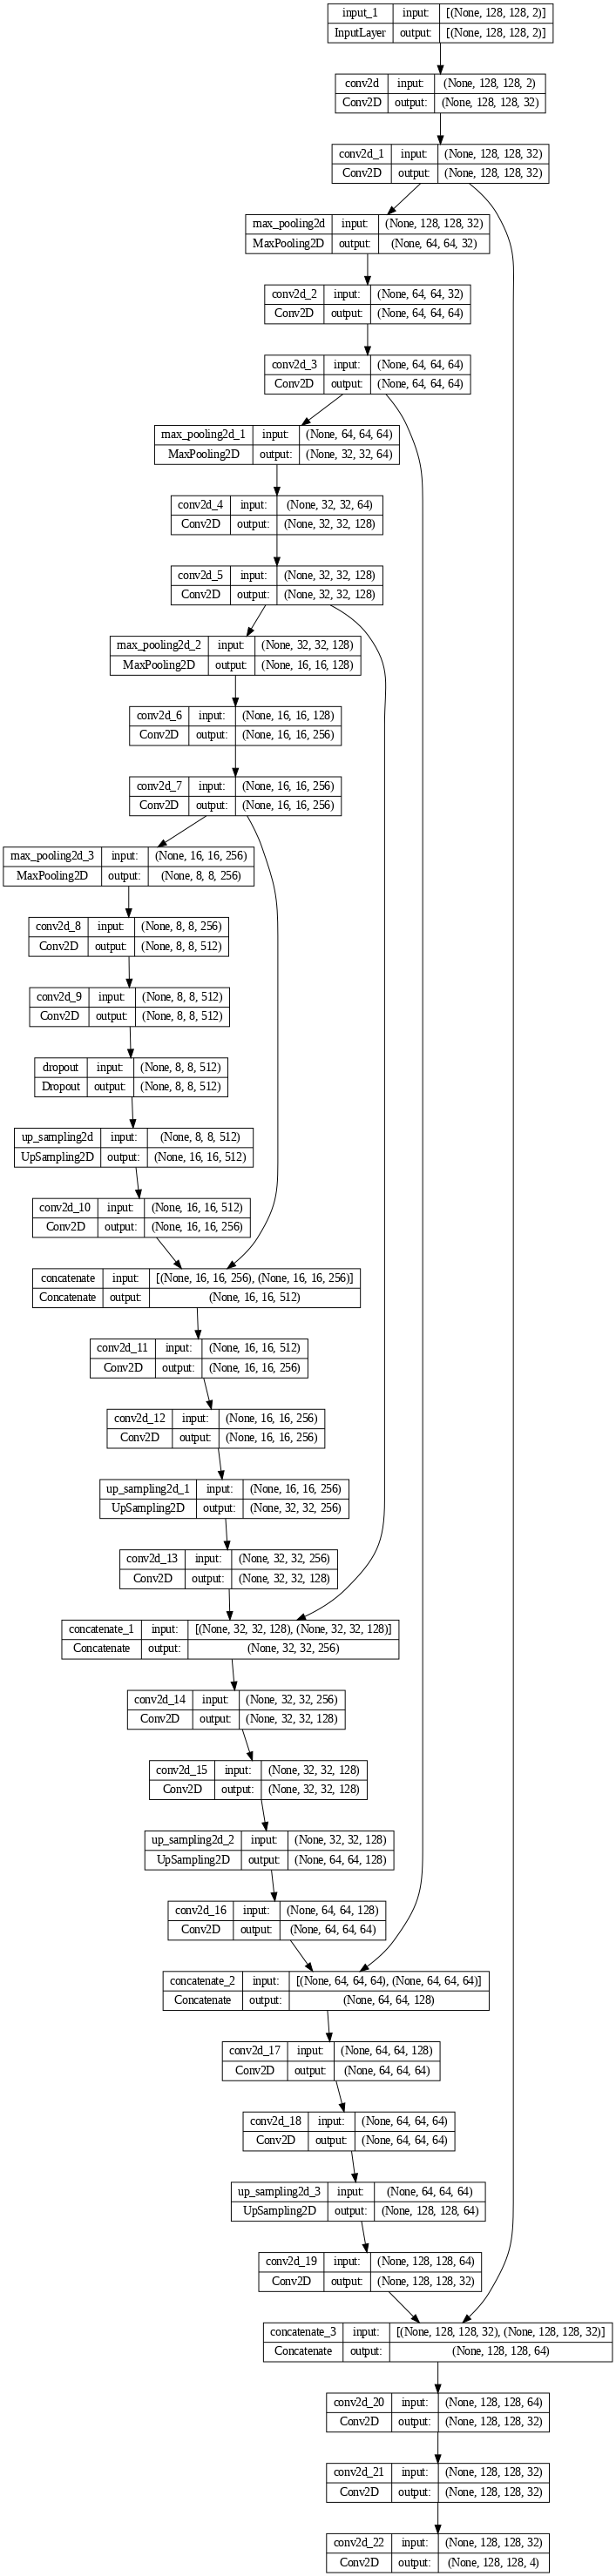

In [ ]:
plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

# Data Loading
Loading all data into memory is not a good idea since the data are too big to fit in.
So we will create dataGenerators - load data on the fly as explained [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

In [ ]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
#train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);


train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [ ]:
train_ids

**Override Keras sequence DataGenerator class**

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}-t2f.nii.gz');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}-t1c.nii.gz');
            ce = nib.load(data_path).get_fdata()

            #data_path = os.path.join(case_path, f'{i}-t1n.nii.gz');
            #t1n = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}-seg.nii.gz');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 #X[j +VOLUME_SLICES*c,:,:,2] = cv2.resize(t1n[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));


                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        #y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        #print(mask.shape)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

**Number of data used**
for training / testing / validation

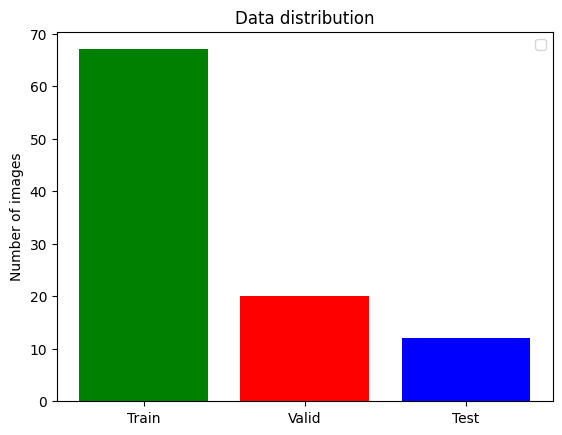

In [ ]:
# show number of data for each dir
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()

showDataLayout()

In [ ]:
pwd

'/content'

**Add callback for training process**

In [ ]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

# Train model
My best model was trained with 81% accuracy on mean IOU and 65.5% on Dice loss <br>
I will load this pretrained model instead of training again

In [ ]:
K.clear_session()

history =  model.fit(training_generator,
                    epochs=200,
                    steps_per_epoch=len(train_ids),
                    callbacks= callbacks,
                    validation_data = valid_generator
                    )
model.save("model_x1_1.h5")

Epoch 1/200
67/67 [==============================] - 114s 1s/step - loss: 0.0565 - accuracy: 0.9907 - mean_io_u: 0.6180 - dice_coef: 0.2622 - precision: 0.9907 - sensitivity: 0.9905 - specificity: 0.9969 - dice_coef_necrotic: 0.1038 - dice_coef_edema: 0.0117 - dice_coef_enhancing: 0.0218 - val_loss: 0.0462 - val_accuracy: 0.9894 - val_mean_io_u: 0.7319 - val_dice_coef: 0.2720 - val_precision: 0.9893 - val_sensitivity: 0.9893 - val_specificity: 0.9964 - val_dice_coef_necrotic: 0.1860 - val_dice_coef_edema: 0.0049 - val_dice_coef_enhancing: 0.0384 - lr: 0.0010
Epoch 2/200
67/67 [==============================] - 86s 1s/step - loss: 0.0509 - accuracy: 0.9907 - mean_io_u: 0.5678 - dice_coef: 0.2647 - precision: 0.9907 - sensitivity: 0.9907 - specificity: 0.9969 - dice_coef_necrotic: 0.1264 - dice_coef_edema: 0.0090 - dice_coef_enhancing: 0.0273 - val_loss: 0.0680 - val_accuracy: 0.9894 - val_mean_io_u: 0.4290 - val_dice_coef: 0.2548 - val_precision: 0.9894 - val_sensitivity: 0.9894 - val_s

In [ ]:
K.clear_session()

history =  model.fit(training_generator,
                    epochs=35,
                    steps_per_epoch=len(train_ids),
                    callbacks= callbacks,
                    validation_data = valid_generator
                    )
model.save("model_x1_1.h5")

Epoch 1/35
67/67 [==============================] - 484s 7s/step - loss: 0.3054 - accuracy: 0.9843 - mean_io_u_1: 0.5329 - dice_coef: 0.2426 - precision: 0.9895 - sensitivity: 0.9227 - specificity: 0.9970 - dice_coef_necrotic: 0.0408 - dice_coef_edema: 0.0028 - dice_coef_enhancing: 0.0077 - val_loss: 0.0641 - val_accuracy: 0.9890 - val_mean_io_u_1: 0.7411 - val_dice_coef: 0.2565 - val_precision: 0.9890 - val_sensitivity: 0.9890 - val_specificity: 0.9963 - val_dice_coef_necrotic: 0.0419 - val_dice_coef_edema: 0.0012 - val_dice_coef_enhancing: 0.0067 - lr: 0.0010
Epoch 2/35
67/67 [==============================] - 81s 1s/step - loss: 0.0524 - accuracy: 0.9908 - mean_io_u_1: 0.5436 - dice_coef: 0.2588 - precision: 0.9907 - sensitivity: 0.9907 - specificity: 0.9969 - dice_coef_necrotic: 0.0802 - dice_coef_edema: 0.0055 - dice_coef_enhancing: 0.0193 - val_loss: 0.0578 - val_accuracy: 0.9890 - val_mean_io_u_1: 0.4253 - val_dice_coef: 0.2638 - val_precision: 0.9889 - val_sensitivity: 0.9889 -

**Visualize the training process**

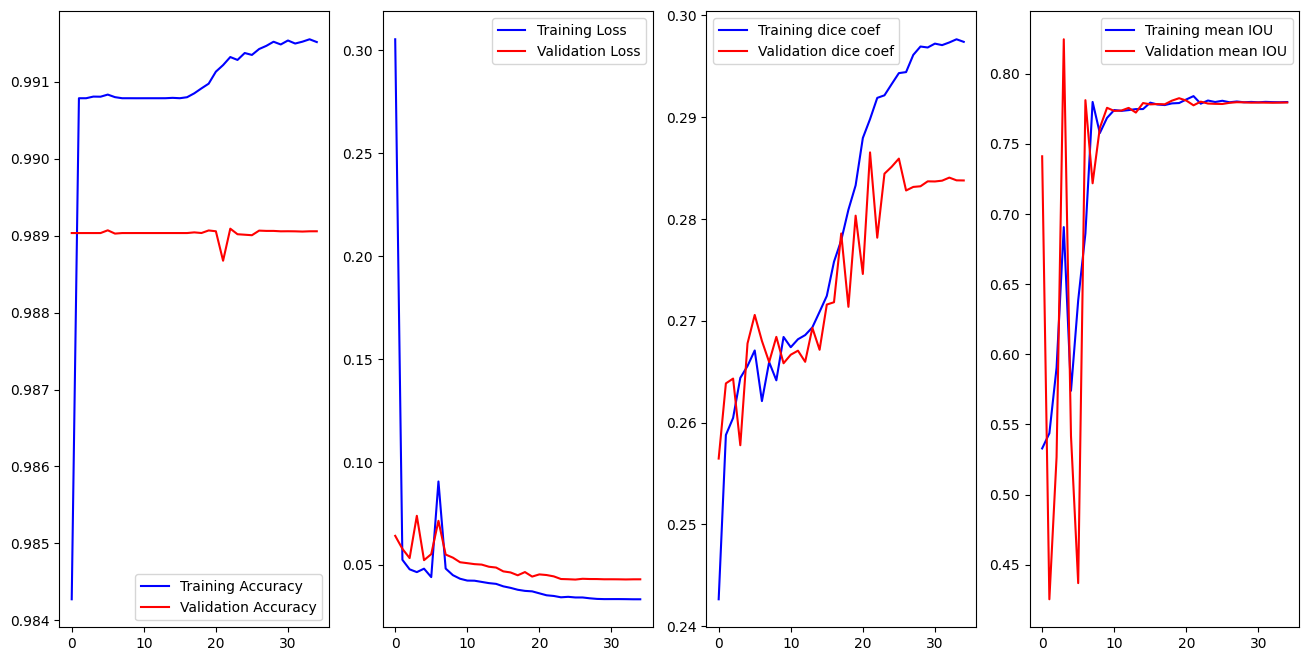

In [ ]:
############ load trained model ################
model = keras.models.load_model('/content/model_x1_1.h5',
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('/content/training.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u_1'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u_1'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

# Prediction examples